In [1]:
import math
import numpy as np
import cv2, os
import pandas as pd
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [2]:
def pca(D, pca_num=20):
    L = np.dot(D, D.T)
    w, v = LA.eig(L)

    # 고유값 0인거 제거    
    zero_eigen = [i for i in range(len(w)) if abs(w[i]) <1e-4]
    j=0
    for i in zero_eigen:
        w = np.delete(w, i-j, axis=0)
        v = np.delete(v, i-j, axis=1)
        j+=1

    # 고유값 내림차순으로 정렬
    ww = np.sort(w.real)[::-1]
    index = np.argsort(w.real)[::-1]  
    vv = np.array([v[:,i].real for i in list(index)]).T 

    ww = ww[:pca_num]
    vv = vv[:, :pca_num]

    u = np.dot(vv.T, D)
    u = u/(LA.norm(u, axis=0))

    weight=np.dot(D,u.T)
    return u, weight

In [3]:
# 유클리디안 짝퉁. sqrt가 계산이오래걸린다니 제곱하는것만 넣었습니당.
# 별로여서 sqrt로! 다시바꿈
## 출력의 shape는 (52,)로 그래프를 그리기 편하게 연출되어있습니다.

def ud(img, eigenvector, img_weight, index):
    test_weight = np.dot(img, eigenvector.T)
    weight = img_weight - test_weight.reshape(1,-1)
    dist = np.sum(weight*weight, axis=1)
    dist = np.sqrt(np.sum(weight*weight, axis=1))
    
    dist = pd.DataFrame(dist.reshape(1,-1), columns=index)
    return dist

In [4]:
def cosine_similarity(img, eigenvector, img_weight, index):
    test_weight = np.dot(img, eigenvector.T)
    dist = np.sqrt(np.sum(test_weight*test_weight))

    cosine_similiarity = np.zeros((1, img_weight.shape[0]))
    for i in range(img_weight.shape[0]):
        cosine_similiarity[0, i]=(np.sum(test_weight*img_weight[i]))/((dist)*(np.sqrt(np.sum(img_weight[i]*img_weight[i]))))
        
    cosine_similiarity = pd.DataFrame(cosine_similiarity.reshape(1,-1), columns=index)
    return cosine_similiarity

In [5]:
def ROC_dir(pca_num=20):
    data_loc = '../au_dataset/'
    filelist = os.listdir(data_loc)

    length = len(filelist)
    imgary = np.zeros((length, 120*100))
    labels = []
    n=0
    for i in filelist:
        tmpimg = cv2.imread(data_loc+i, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))
        imgary[n] = tmpimg
        labels.append(i[0:2])
        n+=1
    
    eigenvector, img_weights = pca(imgary,pca_num)
    
    test_labels = os.listdir("./augmentation/")
    
    cols = labels.copy()
    cols.append("label")
    df= pd.DataFrame(columns = cols)
    
    n=0
    for imgs in test_labels:
        tmpimg = cv2.imread("./augmentation/"+imgs, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))

        df1 = ud(tmpimg, eigenvector, img_weights, labels)
        df1["label"]=imgs[0:2]
        df= pd.concat([df, df1])
        n+=1

    return df

In [5]:
def ROC_dir_cosine(pca_num=20):
    data_loc = '../au_dataset/'
    filelist = os.listdir(data_loc)

    length = len(filelist)
    imgary = np.zeros((length, 120*100))
    labels = []
    n=0
    for i in filelist:
        tmpimg = cv2.imread(data_loc+i, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))
        imgary[n] = tmpimg
        labels.append(i[0:2])
        n+=1
    
    eigenvector, img_weights = pca(imgary,pca_num)
    
    test_labels = os.listdir("./augmentation/")
    
    cols = labels.copy()
    cols.append("label")
    df= pd.DataFrame(columns = cols)
    
    n=0
    for imgs in test_labels:
        tmpimg = cv2.imread("./augmentation/"+imgs, cv2.IMREAD_GRAYSCALE)
        tmpimg = np.reshape(tmpimg, (-1,))

        df1 = cosine_similarity(tmpimg, eigenvector, img_weights, labels)
        df1["label"]=imgs[0:2]
        df= pd.concat([df, df1])
        n+=1

    return df

In [10]:
def plot(pca_num=20):
    df = ROC_dir_cosine(pca_num)
    card = np.unique(df["label"])
    num_card = len(card)
    
    ntrain=int((df.shape[1]-1)/(len(np.unique(df.columns))-1)) # train 갯수
    ntest=int((df.shape[0])/num_card) # test set 갯수
    
    nn = ntrain * ntest
    
    authentic = np.zeros((num_card*nn,))
    imposter = np.zeros((num_card*nn*(num_card-1),))
    

    j=0
    fig = plt.figure(figsize=(10,30))
    #a = np.ceil(num_card/26)
    for i in range(num_card):
        name = card[i]

        for naname in card:
            T_T = np.array(df[df["label"]==name].loc[:, naname:naname]).reshape(-1,)
            if naname == name:
                temp=i*nn
                authentic[temp:temp+nn] = T_T
            else:
                temp = j*nn
                imposter[temp:temp+nn] = T_T
                j+=1 
        
        """ax = fig.add_subplot(26,a, i+1)
        ax.set_title(name)
        plt.hist(authentic[i*nn:(i+1)*nn], color = 'r',  bins=10, alpha = 0.6)
        plt.hist(imposter[i*nn*(num_card-1):(i+1)*nn*(num_card-1)], color = 'b',  bins=10, alpha = 0.6 )
        plt.tight_layout()"""
        
    plt.figure(figsize=(7,5))
    #plt.ylim((0, 4000))
    plt.hist(authentic, color = 'r',  bins=500, alpha = 0.6, label = "authentic")
    plt.hist(imposter, color = 'b',  bins=500, alpha = 0.6, label = "imposter")
    
    #plt.axvline(x=authentic.mean(), color = 'r')
    #plt.axvline(x=imposter.mean(), color = 'b')
    plt.legend()
        
    return  authentic, imposter # authentic.mean(), authentic.std(), imposter.mean(), imposter.std()

In [37]:
def FAR_FRR_cosine (authentic, imposter):
    threshold_array = np.arange(-1,1,0.0001)
    FAR_FRR_len = np.zeros((len(threshold_array),3))
    
    i=0
    auth_len = len(authentic)
    impo_len = len(imposter)
    for threshold in threshold_array:
        FAR_FRR_len[i][0]=threshold
        FAR_FRR_len[i][1]=len(authentic[authentic<threshold])/auth_len
        FAR_FRR_len[i][2]=len(imposter[imposter>threshold])/impo_len
        i+=1
    index = np.argmin(np.abs(FAR_FRR_len[:,1]-FAR_FRR_len[:,2]))
    threshold_EER = FAR_FRR_len[index][0]
    EER = np.mean(FAR_FRR_len[index][1:3])
    
    return threshold_EER,  EER, FAR_FRR_len

In [8]:
def FAR_FRR_ud (authentic, imposter):
    threshold_array = np.arange(0,100000,1000)
    FAR_FRR_len = np.zeros((len(threshold_array),3))
    
    i=0
    auth_len = len(authentic)
    impo_len = len(imposter)
    for threshold in threshold_array:
        FAR_FRR_len[i][0]=threshold
        FAR_FRR_len[i][1]=len(authentic[authentic>threshold])/auth_len
        FAR_FRR_len[i][2]=len(imposter[imposter<threshold])/impo_len
        i+=1
    index = np.argmin(np.abs(FAR_FRR_len[:,1]-FAR_FRR_len[:,2]))
    threshold_EER = FAR_FRR_len[index][0]
    EER = np.mean(FAR_FRR_len[index][1:3])
    
    return threshold_EER,  EER, FAR_FRR_len

In [8]:
data_loc = '../au_dataset/'
filelist = os.listdir(data_loc)

length = len(filelist)
imgary = np.zeros((length, 120*100))
labels = []
n=0
for i in filelist:
    tmpimg = cv2.imread(data_loc+i, cv2.IMREAD_GRAYSCALE)
    tmpimg = np.reshape(tmpimg, (-1,))
    imgary[n] = tmpimg
    labels.append(i[0:2])
    n+=1

In [9]:
eigenvector, img_weights = pca(imgary, 100)

In [13]:
cosine_similarity(imgary[0], eigenvector, img_weights, labels)

,C1,C1,C1,C1,C1,C2,C2,C2,C2,C2,...,SK,SK,SK,SK,SK,SQ,SQ,SQ,SQ,SQ
0,1.0,0.999873,0.999239,0.999072,0.999315,0.997572,0.997465,0.997492,0.99756,0.997492,...,0.997645,0.997845,0.99773,0.997788,0.997819,0.997624,0.997543,0.997701,0.997522,0.997949


In [17]:
ud(imgary[0], eigenvector, img_weights, labels)

,C1,C1,C1,C1,C1,C2,C2,C2,C2,C2,...,SK,SK,SK,SK,SK,SQ,SQ,SQ,SQ,SQ
0,8.225265e-22,1.185308e+09,5.307295e+09,6.716198e+09,6.158372e+09,5.581651e+11,4.968160e+11,5.046014e+11,5.422303e+11,4.866748e+11,...,3.186946e+10,2.433743e+10,2.441269e+10,2.440391e+10,2.657796e+10,2.578345e+10,2.307099e+10,2.025586e+10,2.342022e+10,1.998047e+10


<Figure size 720x2160 with 0 Axes>

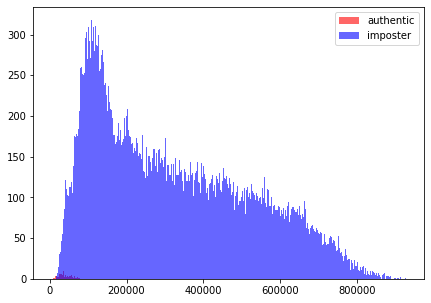

In [16]:
authentic, imposter = plot(50) #ud

In [61]:
df

,C1,C1,C1,C1,C1,C2,C2,C2,C2,C2,...,SK,SK,SK,SK,SQ,SQ,SQ,SQ,SQ,label
0,1.101671e+09,1.294723e+09,3.827623e+09,4.119079e+09,2.398353e+09,6.075273e+11,5.433118e+11,5.516361e+11,5.905253e+11,5.328718e+11,...,2.612365e+10,2.606671e+10,2.605047e+10,2.910428e+10,2.762131e+10,2.396800e+10,2.061935e+10,2.442145e+10,2.092839e+10,C1
0,4.660223e+09,3.162446e+09,1.361035e+09,6.439302e+09,5.266827e+09,6.174561e+11,5.518957e+11,5.610568e+11,6.000749e+11,5.414760e+11,...,2.418495e+10,2.374030e+10,2.399321e+10,2.707520e+10,2.501379e+10,2.082099e+10,1.711426e+10,2.105403e+10,1.840745e+10,C1
0,1.529945e+09,1.073665e+09,6.686231e+09,2.091901e+09,2.769572e+09,5.940373e+11,5.300750e+11,5.388201e+11,5.769492e+11,5.204824e+11,...,2.454653e+10,2.482861e+10,2.468742e+10,2.707409e+10,2.608524e+10,2.269741e+10,1.973381e+10,2.309359e+10,1.978090e+10,C1
0,4.329897e+09,3.951840e+09,5.626265e+07,8.481360e+09,7.101323e+09,5.952353e+11,5.311898e+11,5.399548e+11,5.783283e+11,5.205785e+11,...,2.205192e+10,2.191046e+10,2.194838e+10,2.501929e+10,2.384270e+10,2.030386e+10,1.662937e+10,2.055101e+10,1.735998e+10,C1
0,5.592941e+11,5.827470e+11,5.675169e+11,5.817489e+11,6.095899e+11,4.007119e+08,1.099669e+09,8.412506e+08,2.136486e+08,1.391011e+09,...,4.156442e+11,4.194794e+11,4.174517e+11,4.035580e+11,4.161735e+11,4.375348e+11,4.509789e+11,4.347466e+11,4.399337e+11,C2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.586401e+10,2.769969e+10,2.113302e+10,2.405959e+10,2.812933e+10,4.396797e+11,3.838484e+11,3.906814e+11,4.249361e+11,3.749660e+11,...,6.002604e+08,1.850179e+08,4.261057e+08,9.719868e+08,1.313567e+09,1.096108e+09,1.090349e+09,1.088714e+09,9.408209e+08,SK
0,2.218007e+10,2.294321e+10,1.729999e+10,1.872564e+10,2.192401e+10,4.687944e+11,4.110737e+11,4.184570e+11,4.535327e+11,4.021087e+11,...,2.720191e+09,2.281993e+09,2.583157e+09,2.704424e+09,1.550776e+09,3.939429e+08,9.694261e+08,2.877406e+08,8.746068e+08,SQ
0,2.118015e+10,2.200270e+10,1.606523e+10,1.807780e+10,2.136233e+10,4.690256e+11,4.112721e+11,4.189101e+11,4.537705e+11,4.022163e+11,...,2.180289e+09,1.930967e+09,2.065415e+09,2.493000e+09,1.635642e+09,8.643731e+08,7.442000e+08,5.972551e+08,7.707198e+08,SQ
0,1.885572e+10,1.876185e+10,1.361591e+10,1.458962e+10,1.692231e+10,4.988026e+11,4.391281e+11,4.466241e+11,4.830009e+11,4.298875e+11,...,4.776906e+09,3.981802e+09,4.491328e+09,5.464518e+09,3.868070e+09,1.451423e+09,1.351913e+09,1.546543e+09,1.957689e+09,SQ


In [34]:
threshold_EER,EER,FAR_FRR_len = FAR_FRR_ud(authentic, imposter)

<function matplotlib.pyplot.show(*args, **kw)>

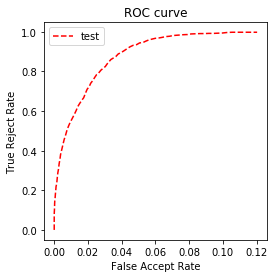

In [38]:
a=1.5
b="--"
plt.figure(figsize=(4,4))
plt.plot(FAR_FRR_len[:,2], 1-FAR_FRR_len[:,1], color="red", label="test", lw=a, ls=b)
plt.legend()
plt.xlabel('False Accept Rate')
plt.ylabel('True Reject Rate')
plt.title('ROC curve')
plt.show

In [9]:
## cosin 유사도

<Figure size 720x2160 with 0 Axes>

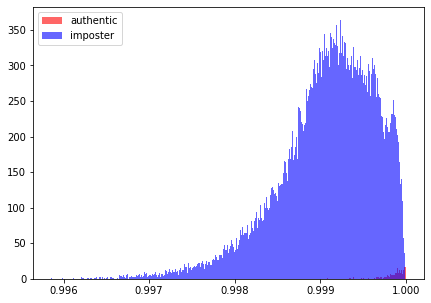

In [11]:
authentic, imposter = plot(50) #cosine

In [43]:
threshold_EER_50,EER_50,FAR_FRR_len_50 = FAR_FRR_cosine(authentic, imposter)

In [41]:
EER

0.11430052790346908

In [45]:
threshold_EER_50

0.9996999999997798

<Figure size 720x2160 with 0 Axes>

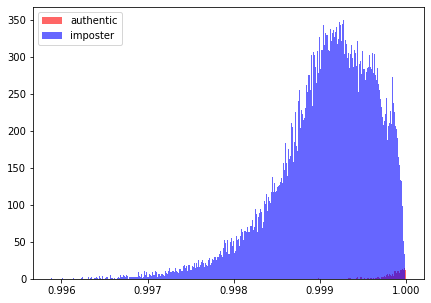

In [44]:
authentic, imposter = plot(100) #cosine
threshold_EER_100,EER_100,FAR_FRR_len_100 = FAR_FRR_cosine(authentic, imposter)

In [48]:
threshold_EER_100, EER_100

(0.9996999999997798, 0.11539404223227753)

<function matplotlib.pyplot.show(*args, **kw)>

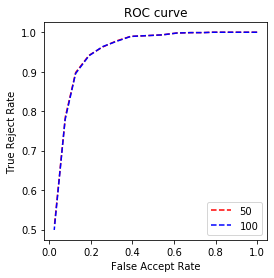

In [49]:
a=1.5
b="--"
plt.figure(figsize=(4,4))
plt.plot(FAR_FRR_len_50[:,2], 1-FAR_FRR_len_50[:,1], color="red", label="50", lw=a, ls=b)
plt.plot(FAR_FRR_len_100[:,2], 1-FAR_FRR_len_100[:,1], color="blue", label="100", lw=a, ls=b)
plt.legend()
plt.xlabel('False Accept Rate')
plt.ylabel('True Reject Rate')
plt.title('ROC curve')
plt.show